In [ ]:
import numpy as np
from scipy import stats

import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm
import statsmodels.stats.diagnostic as smd
import scipy.stats as stats

In [ ]:
rng = np.random.default_rng()
sns.set_style('whitegrid')

### Остатки

Остатки (residuals) - разница между фактическим значением целевой переменной и предсказанным значением

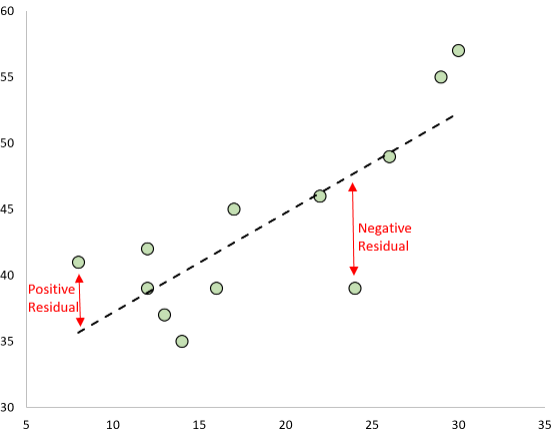

#### **Почему остатки тоже важны, как и метрики?**

#### Ответ



Остатки модели тоже характеризуют качество, но с другой стороны. Анализ остатков проверяет не решения модели, а то, насколько хорошо она замечает взаимосвязи между признаками. Если она не справляется с этим, то уже не важно, близки ли её предсказания к исходным значениям. Модель будет работать нестабильно. Поэтому анализом остатков никогда нельзя пренебрегать, даже если метрики не вызывают подозрений.

#### **Какие свойства мы бы хотели наблюдать (или не наблюдать) в ошибках модели?**

#### Ответ

Используя линейную регрессию, мы предполагаем, что реальная взаимосвязь переменных **линейна**, а отклонения от регрессионной прямой **случайны**, **независимы** между собой и имеют **нулевое среднее** и **постоянную дисперсию**.


### Линейная регрессия - fit/predict

In [ ]:
x = rng.random(10)
y = np.exp(1.6 * x + rng.random(10))

In [ ]:
lin_res = stats.linregress(x, y)
lin_res

LinregressResult(slope=6.064812089096815, intercept=1.6885409660324768, rvalue=0.5938276473668493, pvalue=0.07028917932379011, stderr=2.9052786962366737, intercept_stderr=1.9245250749560698)

In [ ]:
res = lin_res.intercept + lin_res.slope * x

In [ ]:
res_positive_bias = res + 1
res_negative_bias = res - 1

In [ ]:
def plot_regression_line(x, y,data, title):
  plt.plot(x, y, 'o', label='original data')
  plt.plot(x, data, 'r', label='fitted line')
  plt.title(title)
  plt.legend()
  plt.show()

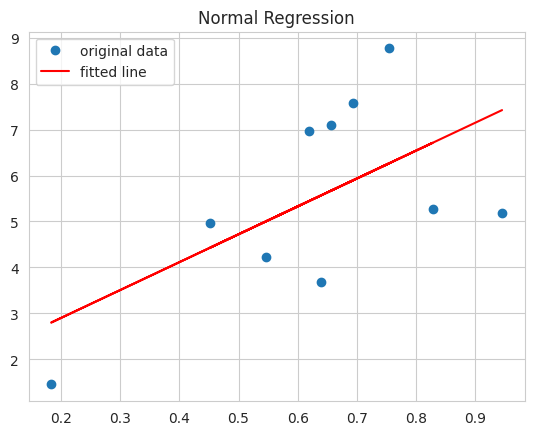

In [ ]:
plot_regression_line(x, y, res, 'Normal Regression')

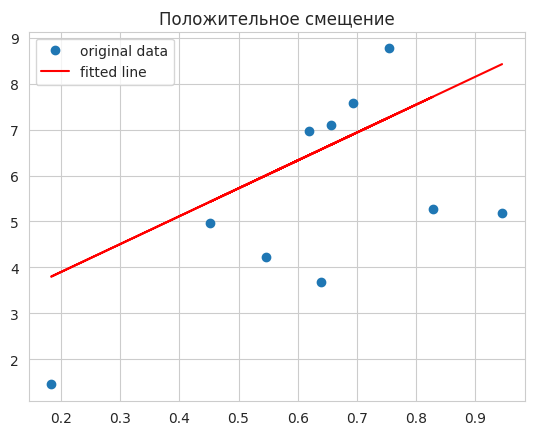

In [ ]:
plot_regression_line(x, y, res_positive_bias, 'Положительное смещение')

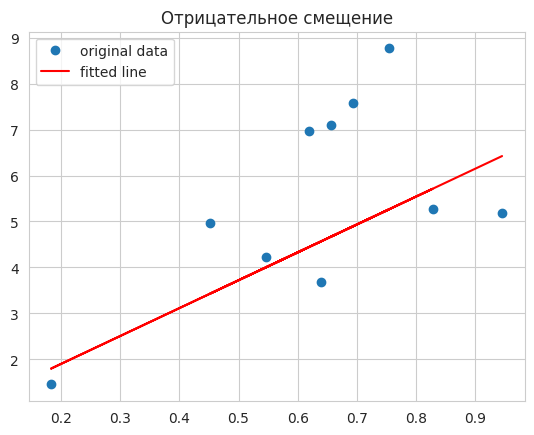

In [ ]:
plot_regression_line(x, y, res_negative_bias, 'Отрицательное смещение')

### Вычисление остатков

In [ ]:
residuals = y - res
residuals_1 = y - res_positive_bias
residuals_2 = y - res_negative_bias

### Распределения остатков

In [ ]:
residuals.mean()

-1.0658141036401502e-15

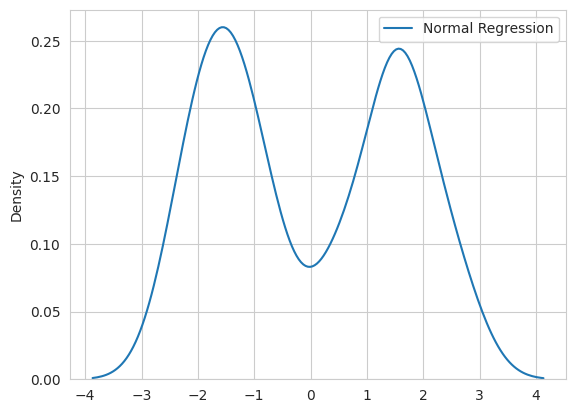

In [ ]:
sns.kdeplot(np.array(residuals), bw_adjust=0.5, label='Normal Regression')
plt.legend();

In [ ]:
residuals_2.mean(), residuals_1.mean()

(0.9999999999999989, -1.000000000000001)

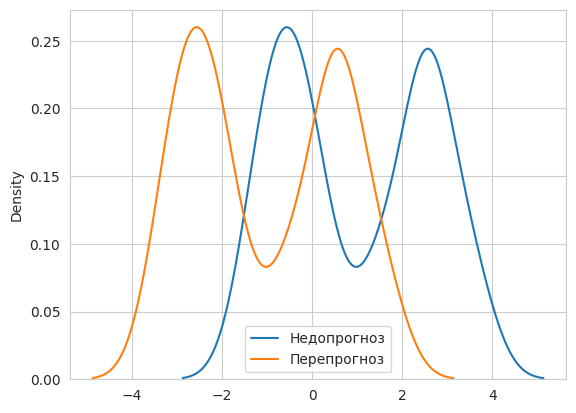

In [ ]:
sns.kdeplot(np.array(residuals_2), bw_adjust=0.5, label='Недопрогноз')
sns.kdeplot(np.array(residuals_1), bw_adjust=0.5, label='Перепрогноз')
plt.legend();

#### Проверка стат. тестом

Свойства распределения можно формулировать в виде статистических гипотез. Так, чтобы оценить наличие или отсутствие смещения (bias), мы сравниваем среднее у распределения остатков с нулём, используя t-тест для одной выборки. Тест учтёт их разброс и отвергнет гипотезу о несмещённости остатков, только если наблюдаемое смещение выходит за рамки погрешности.

На выходе статистического критерия мы получаем p-value — вероятность встретить наблюдаемое значение статистики или более экстремальное при условии, что нулевая гипотеза верна.



In [ ]:
def test_zero_mean(residuals):
  test_res = stats.ttest_1samp(a=residuals, popmean=0)
  print(test_res)
  if test_res.pvalue < 0.05:
    print('Среднее остатков не равно 0')
  else:
    print('Среднее остатков равно 0')

In [ ]:
test_zero_mean(residuals)

TtestResult(statistic=-1.9520754616750436e-15, pvalue=0.9999999999999984, df=9)
Среднее остатков равно 0


In [ ]:
test_zero_mean(residuals_1) # поправить

TtestResult(statistic=-1.8315346503747552, pvalue=0.10025099249726148, df=9)
Среднее остатков равно 0


Для всех случаев ненормального распределения данных подходят два совета:

- Найти и добавить в модель дополнительные признаки. Скорее всего, на этапе сбора данных не была учтена какая-то информация.
- Трансформировать данные, чтобы изменить взаимосвязь входных признаков с целевым.

### Дисперсия остатков

<Axes: >

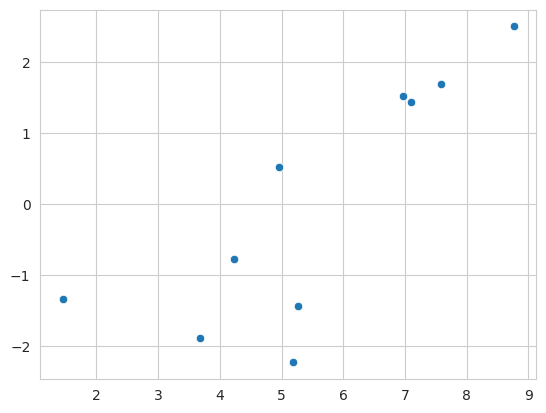

In [ ]:
sns.scatterplot(x=y, y=residuals)

In [ ]:
good_y = 1.6 * x + rng.random(10)
lin_res = stats.linregress(x, good_y)
good_res = lin_res.intercept + lin_res.slope * x

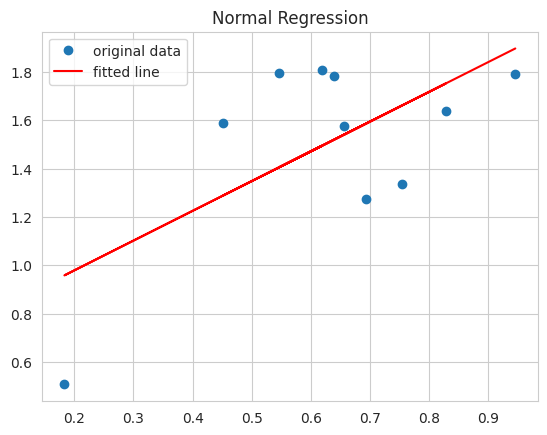

In [ ]:
plot_regression_line(x, good_y, good_res, 'Normal Regression')

<Axes: >

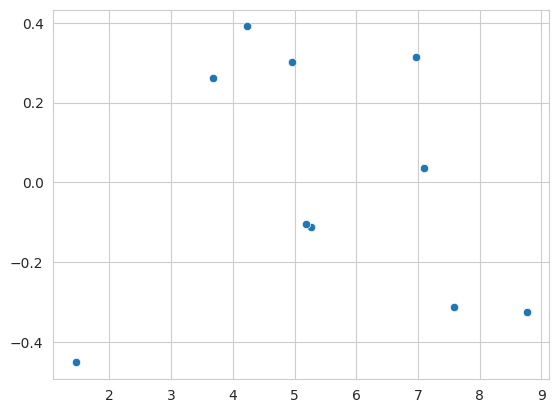

In [ ]:
good_residuals = good_y - good_res
sns.scatterplot(x=y, y=good_residuals)

Видно, что разница между минимумом и максимумом остатков при любых прогнозных значениях модели остается в +- одинаковом диапазоне. Дисперсия между значениями на оси Y постоянна на протяжении всей оси X. Это говорит о высоком качестве модели, поскольку она равномерно ошибается.

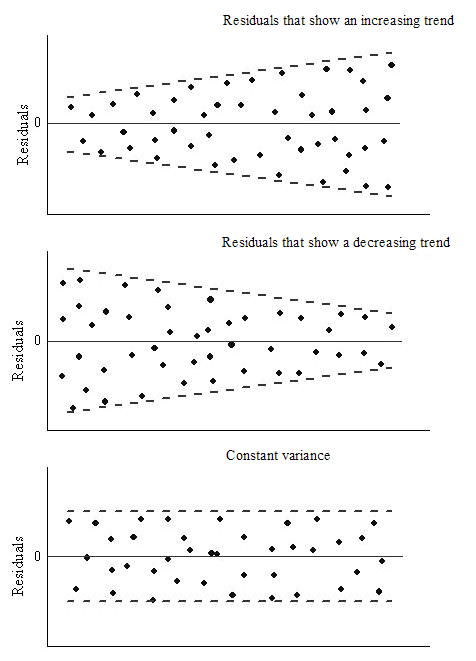

Критически важно, чтобы дисперсия остатков была постоянной. Иначе модель станет непредсказуемой, а её прогнозы — ненадёжными. Поэтому неравномерную дисперсию необходимо устранять.

Что делать? Рецепты — те же, что и в случае смещённого распределения на гистограмме

#### Более интересный пример

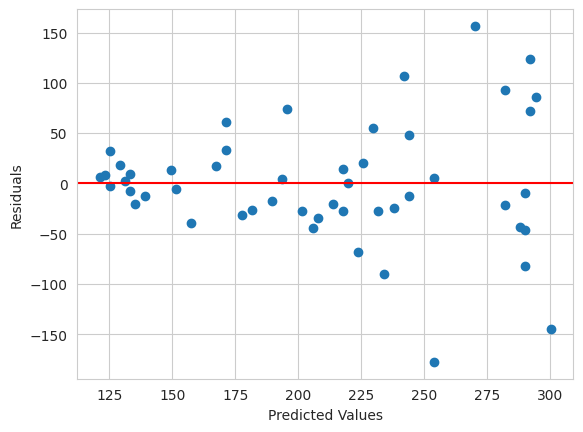

In [ ]:
n = 50
X = np.random.randint(0, 100, n)
epsilon = np.random.normal(0, 1, n)
Y_heteroscedastic = 100 + 2*X + epsilon*X

model = sm.OLS(Y_heteroscedastic, sm.add_constant(X)).fit()
B0, B1 = model.params
residuals = model.resid

plt.scatter(model.predict(), residuals);
plt.axhline(0, color='red')
plt.xlabel('Predicted Values');
plt.ylabel('Residuals');

#### Проверка стат. тестом - тест Бройша-Пагана

Один из статистических тестов для проверки наличия гетероскедастичности случайных ошибок регрессионной модели.

In [ ]:
def variance_test(residual_values, x):
  breusch_pagan_p = smd.het_breuschpagan(residual_values, x)[1]
  print(breusch_pagan_p)
  if breusch_pagan_p > 0.05:
      print("Дисперсия остатков постоянна")
  if breusch_pagan_p < 0.05:
      print("Дисперсия остатков не постоянна")

In [ ]:
variance_test(residuals, model.model.exog)

0.0007369539357887866
Дисперсия остатков не постоянна


In [ ]:
Y_heteroscedastic_log = np.log(Y_heteroscedastic)

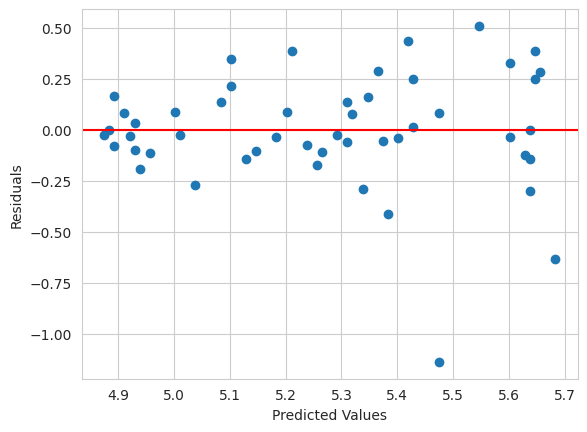

In [ ]:
model = sm.OLS(Y_heteroscedastic_log, sm.add_constant(X)).fit()
B0, B1 = model.params
residuals = model.resid

plt.scatter(model.predict(), residuals);
plt.axhline(0, color='red')
plt.xlabel('Predicted Values');
plt.ylabel('Residuals');

In [ ]:
variance_test(residuals, model.model.exog)

0.056655928302511184
Дисперсия остатков постоянна


После обучения модели на логарифмированном таргете нужно сделать обратный преобразование - exp!

### Автокорреляция остатков

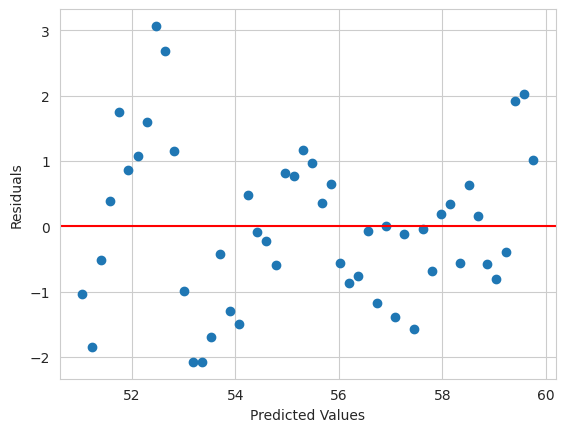

In [ ]:
n = 50
X = np.linspace(0, n, n)
Y_autocorrelated = np.zeros(n)
Y_autocorrelated[0] = 50
for t in range(1, n):
    Y_autocorrelated[t] = Y_autocorrelated[t-1] + np.random.normal(0, 1)

model = sm.OLS(Y_autocorrelated, sm.add_constant(X)).fit()
B0, B1 = model.params
residuals = model.resid

plt.scatter(model.predict(), residuals);
plt.axhline(0, color='red')
plt.xlabel('Predicted Values');
plt.ylabel('Residuals');

#### Проверка стат. тестом - тест Льюнг-Бокса

Как и в случае со всеми статистическими свойствами, нам требуется статистический тест, чтобы в конечном итоге решить, есть ли автокорреляция в  остатках или нет. Для этого мы используем тест Льюнг-Бокса

In [ ]:
def autocorr_test(residual_values):
  ljung_box = smd.acorr_ljungbox(residual_values, lags=10, return_df=True)
  print("\nP-values:", ljung_box.lb_pvalue.tolist(), "\n")

  if (ljung_box.lb_pvalue < 0.05).any():
      print("Остатки коррелированы.")
  else:
      print("Остатки не коррелированы.")

In [ ]:
autocorr_test(residuals)


P-values: [4.133161752261787e-06, 1.0447855838765068e-06, 4.498148190082992e-06, 1.4662388379110882e-05, 2.6778485415051894e-05, 1.1962830649839637e-05, 9.328043886520891e-07, 3.907961510603113e-08, 9.29774164351801e-09, 6.161393612301331e-09] 

Остатки коррелированы.


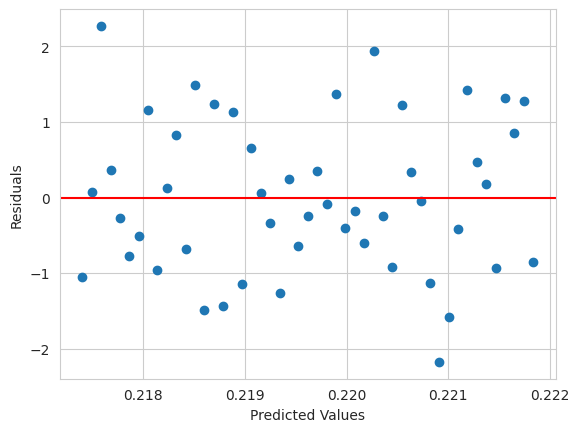

In [ ]:
Y_autocorrelated_diff = np.diff(Y_autocorrelated)
model = sm.OLS(Y_autocorrelated_diff, sm.add_constant(X[1:])).fit()
B0, B1 = model.params
residuals = model.resid

plt.scatter(model.predict(), residuals);
plt.axhline(0, color='red')
plt.xlabel('Predicted Values');
plt.ylabel('Residuals');

In [ ]:
autocorr_test(residuals)


P-values: [0.2748694829025149, 0.4656548110115337, 0.07385367506436612, 0.11728064441819187, 0.1911920440242768, 0.2737758210958279, 0.31566599243497195, 0.34187563404304777, 0.43666002465299036, 0.5307657972992079] 

Остатки не коррелированы.


### Немного умных слов

Метод Наименьших Квадратов работает (== коэффициенты, выученные линейной регрессии получатся хорошие 😺), если данные обладают свойствами Гаусса-Маркова:

$E(ε_i)=0$ — математическое ожидание ошибки равно 0

$σ^2(ε_i)=const$ — гомоскедастичность == постоянство дисперсии

$cov(ε_i,ε_j)=0,i≠j$ — отсутствие мультиколлинеарности

$x_i$ — детерминированная величина

$ε ~ N(0,σ^2)$ — ошибка нормально распределена